In [1]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras import models
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3
import random
import matplotlib.image as mpimg
import PIL
import PIL.Image
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input, Activation, BatchNormalization


In [2]:
data_path = r"D:\project\disater_1\disa"
pre_disaster =r"D:\project\disater_1\disa\pre_disaster"
post_disaster = r"D:\project\disater_1\disa\post_disaster"
pre_mask = r"D:\project\disater_1\disa\pre_mask"
post_mask =r"D:\project\disater_1\disa\post_mask"

In [3]:
print(data_path)

D:\project\disater_1\disa


In [4]:

# Image dimensions and batch size
img_width, img_height = 150, 150
batch_size = 32
data_path=r"D:\project\disater_1\disa"


 """
    Creates a binary mask for the given image.

    Args:
        image_path (str): Path to the image.
        threshold_value (int): Threshold value to separate foreground and background.

    Returns:
        np.ndarray: The binary mask.
    """

#pre disaster mask images 

In [5]:
def create_binary_mask(image_path, threshold_value):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)
    return mask

# Specify the input and output folder paths
input_folder = "D:\project\disater_1\disa\pre_disaster"
output_folder = "D:\project\disater_1\disa\pre_mask"

# Threshold value for binary thresholding
threshold_value = 128 

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process the images
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for your image formats
        image_path = os.path.join(input_folder, filename)
        mask = create_binary_mask(image_path, threshold_value)
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, mask)

#post disaster mask images 

In [6]:

def create_binary_mask(image_path, threshold_value):
    
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)
    return mask

# Specify the input and output folder paths
input_folder = "D:\project\disater_1\disa\post_disaster"
output_folder = "D:\project\disater_1\disa\post_mask"

# Threshold value for binary thresholding
threshold_value = 128  # Adjust as needed

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process the images
for filename in os.listdir(input_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust for your image formats
        image_path = os.path.join(input_folder, filename)
        mask = create_binary_mask(image_path, threshold_value)
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, mask)

In [5]:
# Load the PNG image
image = cv2.imread('D:\project\disater_1\disa\pre_disaster\guatemala-volcano_00000004_pre_disaster.png', cv2.IMREAD_UNCHANGED)

# Split into bands (assuming the image has NIR in one of its channels)
nir_band = image[:, :, 3]  # Assuming NIR is in the 4th channel
red_band = image[:, :, 2]  # Red is in the 3rd channel

# Normalize bands to the range [0, 1] if needed
nir_band = nir_band / 255.0
red_band = red_band / 255.0


In [6]:
# Avoid division by zero using np.errstate
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    ndvi = np.nan_to_num(ndvi)  # Replace NaNs with zero


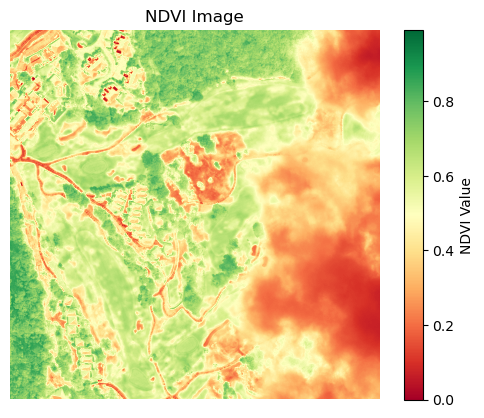

In [7]:
# Plot the NDVI
plt.imshow(ndvi, cmap='RdYlGn')  # Red-Yellow-Green colormap
plt.colorbar(label='NDVI Value')
plt.title('NDVI Image')
plt.axis('off')
plt.show()


In [8]:
# Scale NDVI to range [0, 255] for saving as PNG
ndvi_scaled = ((ndvi - np.min(ndvi)) / (np.max(ndvi) - np.min(ndvi)) * 255).astype(np.uint8)

# Save NDVI as a grayscale PNG image
cv2.imwrite('ndvi_image.png', ndvi_scaled)


True

In [9]:
# Load NDVI image (assumes it's already computed and saved)
ndvi_image = cv2.imread('D:\project\disater_1\disa\pre_disaster\guatemala-volcano_00000004_pre_disaster.png', cv2.IMREAD_GRAYSCALE)

# Convert NDVI from 0-255 range back to original NDVI scale (-1 to 1) if necessary
ndvi = (ndvi_image / 255.0) * 2 - 1  # Only if saved as scaled PNG

# Define NDVI thresholds and their corresponding colors (RGB)
color_mask = np.zeros((*ndvi.shape, 3), dtype=np.uint8)  # Initialize a blank color mask

# Apply colors based on NDVI thresholds
color_mask[ndvi < 0] = [0, 0, 255]  # Blue for water/non-vegetation
color_mask[(ndvi >= 0) & (ndvi < 0.2)] = [165, 42, 42]  # Brown for bare soil
color_mask[(ndvi >= 0.2) & (ndvi < 0.5)] = [255, 255, 0]  # Yellow for low vegetation
color_mask[ndvi >= 0.5] = [0, 255, 0]  # Green for high vegetation

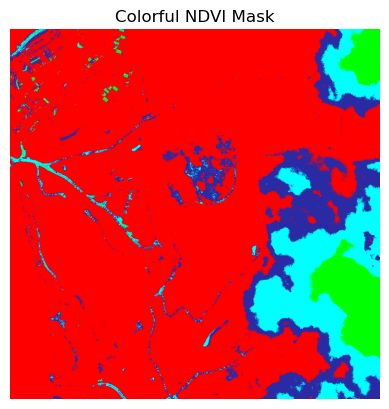

In [10]:
plt.imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title('Colorful NDVI Mask')
plt.axis('off')
plt.show()


In [11]:
# 1. Data Preprocessing using ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Split data for validation
)

# Define data directories (replace with your actual paths)
train_data_dir = ''
img_height, img_width = 150, 150 # Define image size
batch_size = 32 # Define batch size

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # 'binary' for 2 classes, 'categorical' for >2
    subset='training' # Specify training subset
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation' # Specify validation subset
)


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/sheetal_12_04/project_disaster_pred/disas-20241220T121558Z-002/disas'

In [12]:
# # Train_dataset :




# train_ds=image_dataset_from_directory(
#          data_path,
#          validation_split=0.2,
#          subset="training",
#          seed=123,
#          image_size=(img_height,img_width),
#          batch_size=batch_size)


# # validation dataset
# val_ds=image_dataset_from_directory(
#          data_path,
#          validation_split=0.2,
#          subset="validation",
#          seed=123,
#          image_size=(img_height,img_width),
#          batch_size=batch_size)




# # to know the shape of the image & Number of class :
# for image_batch, labels_batch in train_ds:
#     #true_labels = labels.numpy()
#     print(image_batch.shape) 
#     break

Found 312 files belonging to 2 classes.
Using 250 files for training.
Found 312 files belonging to 2 classes.
Using 62 files for validation.
(32, 150, 150, 3)


In [27]:
# from sklearn.model_selection import train_test_split

# # Split the data
# x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_X, TRAIN_Y, test_size=0.2, shuffle= True)

NameError: name 'TRAIN_X' is not defined

In [13]:
# to know classnames of dataset :

class_names=train_ds.class_names
num_classes = len(class_names)
print(f"found {num_classes} classes\n classes_names:{class_names}")

found 2 classes
 classes_names:['post_disaster', 'pre_disaster']


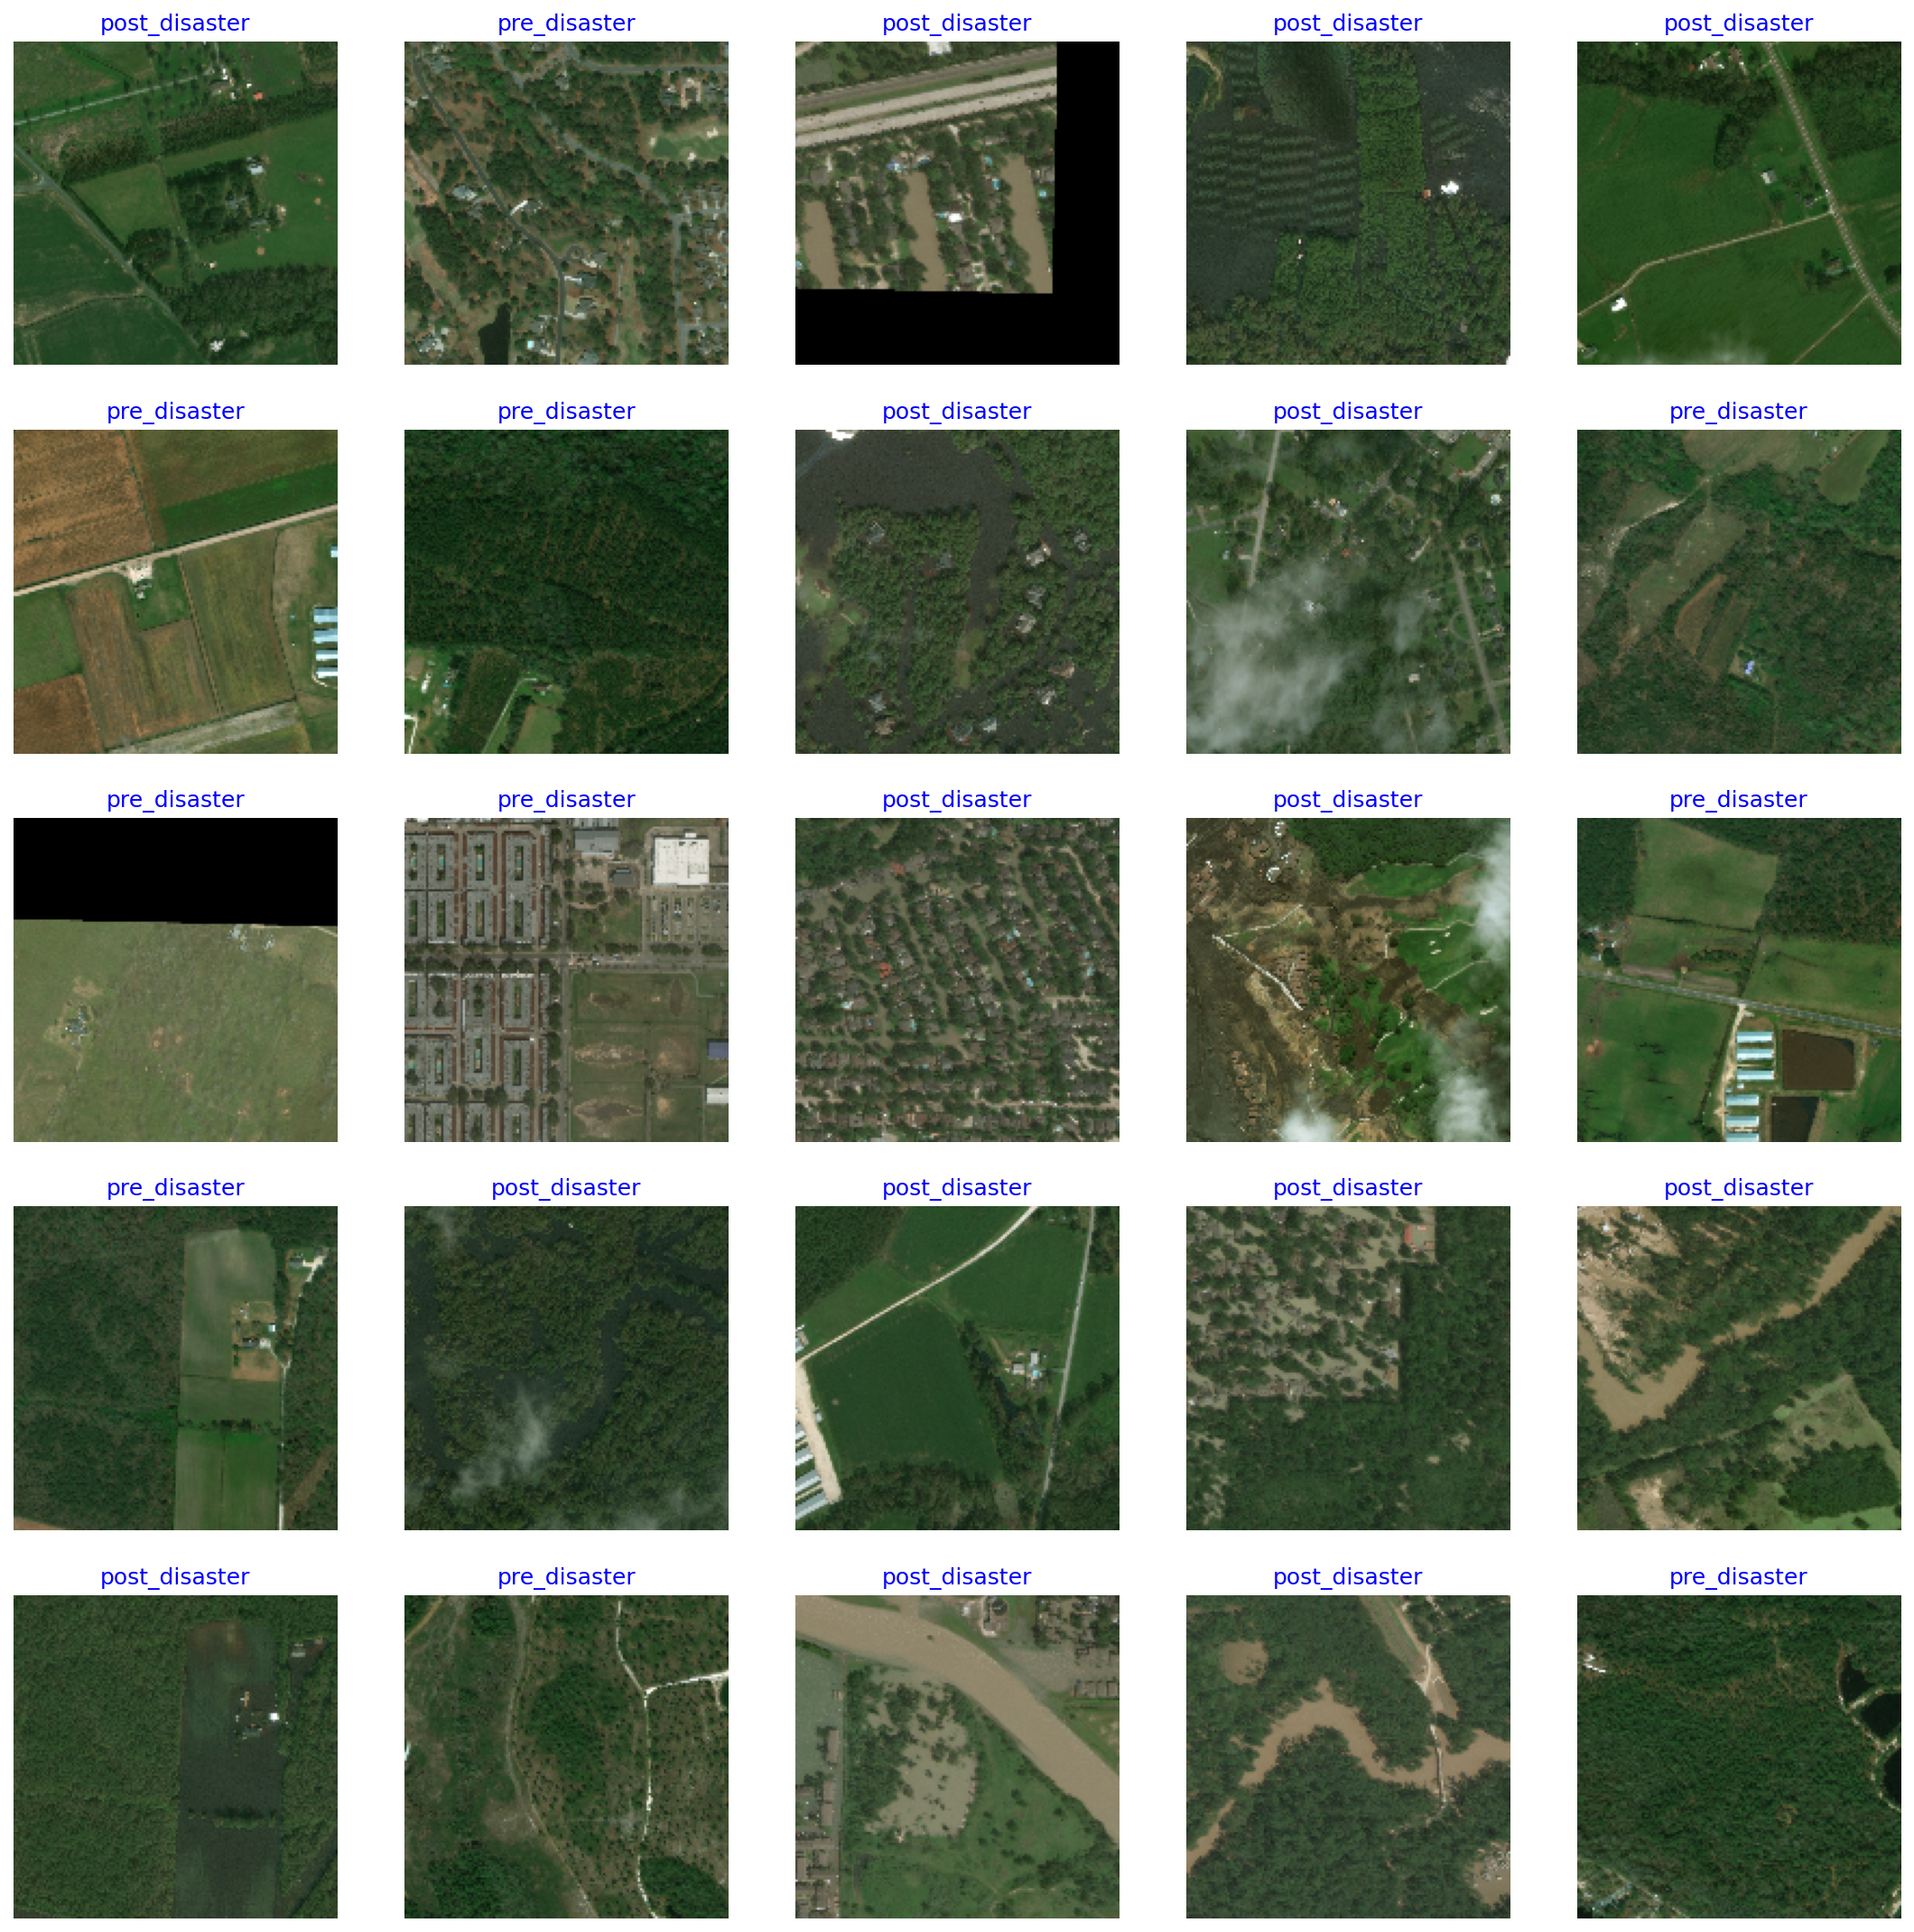

In [14]:
f={ 
    'style': 'normal',
    'weight': 'normal',
    'size': 12,
    'color': '#0000FF'
        }

plt.figure(figsize=(18,18),dpi=150)

for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]],fontdict=f)
        plt.axis("off")

In [15]:
# function that read the image & conver into jpeg:

def get_image_tensor_from_path(image_path,label):
    image=tf.io.read_file(image_path)
    image=tf.image.decode_jpeg(image)
    image=tf.image.convert_image_dtype(image,tf.float32)
    image=tf.image.resize(image,(150,150))


    return image , label

In [16]:
# function to change from brightness or reloation of the image :
def agument(image,label):
    image=tf.image.random_brightness(image,max_delta=32.0/255.0) # change from brightness of image

    image=tf.image.random_flip_left_right(image) # change from position of image

    image=tf.image.random_flip_up_down(image)

    image=tf.image.random_saturation(image,lower=500000,upper=1000000)      # to change preentage of color in image


    return image , label

In [17]:
def cd_dataset(x,y,batch_size=32,training=False):
    data=tf.data.Dataset.from_tensor_slices((x,y))

    data=data.map(get_image_tensor_from_path,num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if training:

        data=data.map(agument,num_parallel_calls=tf.data.experimental.AUTOTUNE)

        data=data.shuffle(2000)

        data=data.batch(batch_size)

        data=data.prefetch(tf.data.experimental.AUTOTUNE)
        return data

In [18]:
# preprocessing the data :
def reshape_and_normalize(images_data):
     # reshape :
    images=images.reshape(images_data.reshape[0],images_data.reshape[1],images_data.reshape[2],1)
    
    #Normalize :
    images=images_data/255
    return images

In [19]:
# Convert labels to one-hot encoding using tf.one_hot

class_names = train_ds.class_names
num_classes = len(class_names)

def one_hot_encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds = train_ds.map(one_hot_encode_labels)
val_ds = val_ds.map(one_hot_encode_labels)

In [20]:
# Define a Callback class that stops training once accuracy reaches 99.9%

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True

In [21]:
# Bulding the model :

print("\n CNN MODEL :")
model=Sequential([
    # first CNN_layer
    Conv2D(64,(3,3),input_shape=(img_height,img_width,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # second layer
    Conv2D(64,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    #third layer
    Conv2D(128,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    #fourth layer:
    Conv2D(64,(3,3),activation="relu"),
     BatchNormalization(),
    MaxPooling2D(2,2),

    #fifth layer:
    Conv2D(32,(3,3),activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512,activation="relu"),
    BatchNormalization(),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    # output layer:

    Dense(2,activation="softmax")
    
])

model.summary()

# compile the model :


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

callbacks=myCallback()

# training the model :

print("\n model Training :")

history=model.fit(

    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=2,
    callbacks=[callbacks]
)


 CNN MODEL :


d:\New folder\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 307,554 (1.17 MB)

 Trainable params: 305,698 (1.17 MB)

 Non-trainable params: 1,856 (7.25 KB)


 model Training :
Epoch 1/20
8/8 - 15s - 2s/step - accuracy: 0.4800 - loss: 1.2834 - val_accuracy: 0.5645 - val_loss: 1.0202
Epoch 2/20
8/8 - 8s - 1s/step - accuracy: 0.6880 - loss: 0.6851 - val_accuracy: 0.5806 - val_loss: 1.0088
Epoch 3/20
8/8 - 8s - 1s/step - accuracy: 0.7920 - loss: 0.4713 - val_accuracy: 0.5645 - val_loss: 0.7791
Epoch 4/20
8/8 - 7s - 928ms/step - accuracy: 0.8240 - loss: 0.4230 - val_accuracy: 0.4677 - val_loss: 0.7830
Epoch 5/20
8/8 - 7s - 888ms/step - accuracy: 0.8840 - loss: 0.2750 - val_accuracy: 0.3710 - val_loss: 0.7667
Epoch 6/20
8/8 - 7s - 893ms/step - accuracy: 0.9240 - loss: 0.2017 - val_accuracy: 0.5806 - val_loss: 0.8769
Epoch 7/20
8/8 - 7s - 894ms/step - accuracy: 0.9440 - loss: 0.1633 - val_accuracy: 0.5806 - val_loss: 0.9044
Epoch 8/20
8/8 - 7s - 891ms/step - accuracy: 0.9720 - loss: 0.1076 - val_accuracy: 0.5484 - val_loss: 0.7649
Epoch 9/20
8/8 - 7s - 889ms/step - accuracy: 0.9680 - loss: 0.1116 - val_accuracy: 0.4194 - val_loss: 0.8279
Epoch 10

In [22]:
threshold = 0.5
pred_img = model.predict(val_ds)
pred_img = (pred_img > threshold).astype(np.uint8)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step


In [23]:
print("\n Model Prediction :")
y_predict=model.predict(val_ds)
y_predict[:10]


 Model Prediction :
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


array([[0.31162524, 0.6883747 ],
       [0.8224466 , 0.17755337],
       [0.5111003 , 0.48889968],
       [0.3917365 , 0.6082635 ],
       [0.7808379 , 0.21916206],
       [0.3857684 , 0.6142315 ],
       [0.855335  , 0.14466502],
       [0.69295806, 0.30704197],
       [0.63585526, 0.3641448 ],
       [0.8723443 , 0.12765566]], dtype=float32)

In [24]:
# compute min & max in the y_prediction:
print(f"the min_value for prediction --->> {np.min(y_predict)} \n the max_value for prediction --->>> {np.max(y_predict)} ")

the min_value for prediction --->> 0.0440480001270771 
 the max_value for prediction --->>> 0.955951988697052 


In [25]:
# Model Evalution :
print("\n Model Evalute :")
model.evaluate(val_ds)



 Model Evalute :
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.5007 - loss: 0.7951


[0.7623636722564697, 0.5322580933570862]

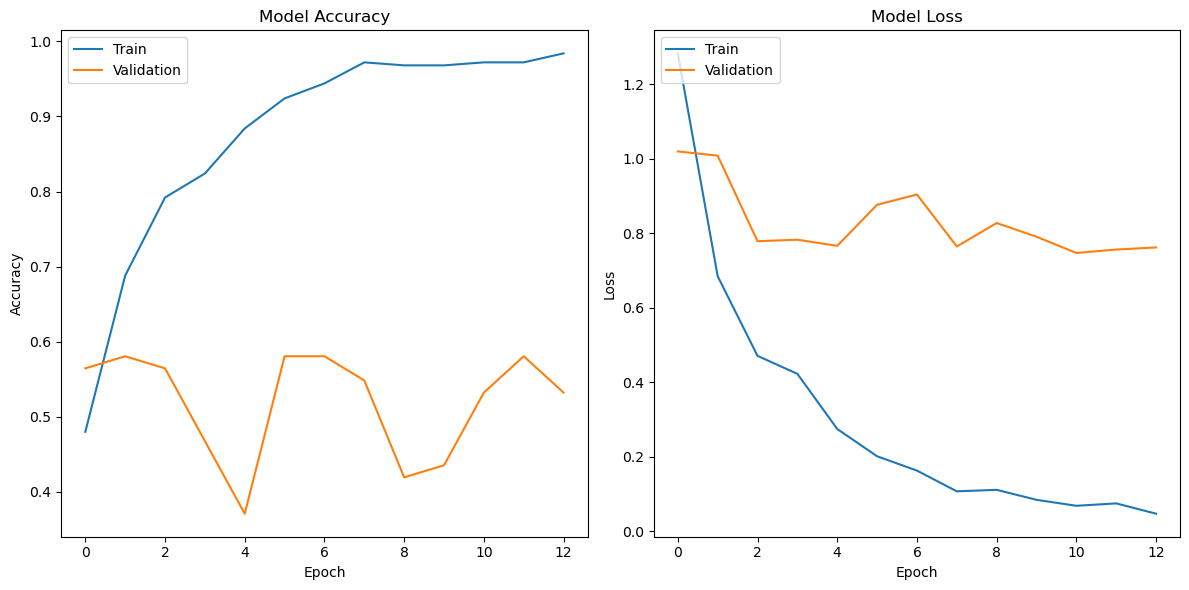

In [26]:
#Plotting training history (accuracy and loss)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
def predict_on_dataset(dataset):
  """
  Makes predictions on a given image dataset.

  Args:
      dataset: A TensorFlow image dataset (e.g., train_ds or val_ds).

  Returns:
      A NumPy array containing the predicted class labels or probabilities.
  """
  predictions = []
  for images, labels in dataset:
    # Make predictions on the current batch of images
    predicted_batch = model.predict(images)

    # Extract the predicted class labels (or probabilities, depending on your output layer)
    predicted_labels = predicted_batch.argmax(axis=1)  # For class labels
    # predicted_labels = predicted_batch  # For class probabilities (modify if needed)

    predictions.extend(predicted_labels.tolist())
  return np.array(predictions)

In [28]:
train_predictions = predict_on_dataset(train_ds)
print("Predicted labels on training set:", train_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
Predicted labels on training set: [0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1
 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 0
 1 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1
 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1
 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0
 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1
 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]


In [29]:
val_predictions = predict_on_dataset(val_ds)
print("Predicted labels on validation set:", val_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted labels on validation set: [1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1
 1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1]


In [30]:
val_predictions = predict_on_dataset(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


d:\New folder\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


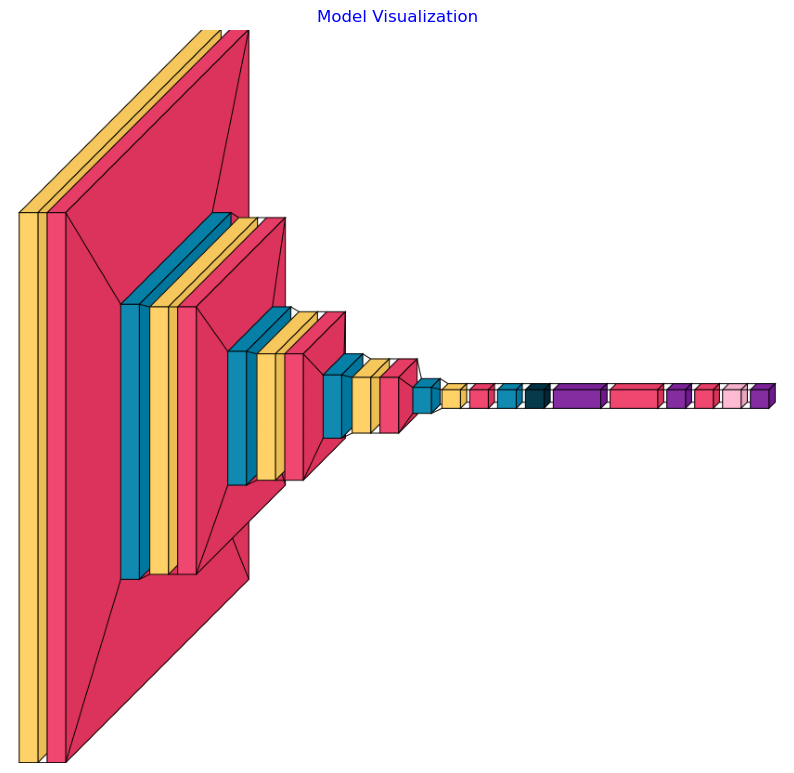

In [32]:
import visualkeras
from PIL import Image

# Save the visualization as an image file
visualization_path = 'model_visualization.png'
visualkeras.layered_view(model).save(visualization_path)

# Display the image using matplotlib
img = Image.open(visualization_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Model Visualization",fontdict=f)
plt.axis('off')
plt.show()

In [38]:
# Assuming the dataset is created from a directory where each subdirectory represents a class
data_path = r"D:\project\disater_1\disa"
class_names = sorted(os.listdir(data_path))  # List subdirectories (classes)

# Use these class names in predictions
print("Class Names:", class_names)


Class Names: ['post_disaster', 'pre_disaster']


In [42]:
# Map predicted indices to class names
predicted_class_names = [class_names[pred] for pred in predicted_classes]

# Map true labels to class names
true_class_names = [class_names[true] for true in true_labels]

print("Predicted Class Names:", predicted_class_names)
print("True Class Names:", true_class_names)


Predicted Class Names: ['pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster'

In [41]:
# Ensure true_labels is converted to integer indices
if len(true_labels.shape) > 1:  # Check if labels are one-hot encoded
    true_labels = np.argmax(true_labels, axis=1)

# Map true labels to class names
true_class_names = [class_names[true] for true in true_labels]

# Output predictions and true labels
print("Predicted Class Names:", predicted_class_names)
print("True Class Names:", true_class_names)


Predicted Class Names: ['pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'post_disaster', 'pre_disaster', 'post_disaster', 'pre_disaster', 'pre_disaster', 'post_disaster'

In [44]:
print("True Labels Shape:", true_labels.shape)
print("True Labels Example:", true_labels[:5])


True Labels Shape: (62, 2)
True Labels Example: [[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [47]:
# Get predictions for the entire validation dataset
predictions = model.predict(val_ds)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the validation dataset
true_labels = np.concatenate([labels.numpy() for _, labels in val_ds])

# Class names
Class_names = train_ds.class_names

# Map predicted indices to class names
predicted_class_names = [Class_names[pred] for pred in predicted_classes]

# Print predictions and true labels
print("Predictions:", predicted_class_names)
print("True Labels:", [Class_names[true] for true in true_labels])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


AttributeError: '_MapDataset' object has no attribute 'class_names'